In [1]:
from qiskit import  Aer, ClassicalRegister, QuantumRegister, QuantumCircuit, execute
# import basic plot tools
from qiskit.visualization import plot_histogram
import numpy as np

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [2]:
def comparer():   
    comparerCircuit = QuantumCircuit(15)

    for i in range(3) : 
        comparerCircuit.x(5 * i + 1)
        
        comparerCircuit.ccx(5 * i + 0, 5 * i + 1, 5 * i + 2)

        comparerCircuit.x(5 * i + 0)
        comparerCircuit.x(5 * i + 1)
            
        comparerCircuit.ccx(5 * i + 0, 5 * i + 1, 5 * i + 3)

        comparerCircuit.x(5 * i + 0)

    for i in range(2) :
        comparerCircuit.x(5 * i + 2)
        comparerCircuit.x(5 * i + 3)
        
        comparerCircuit.ccx(5 * i + 2, 5 * i + 3, 5 * i + 4)
        
        comparerCircuit.x(5 * i + 2)
        comparerCircuit.x(5 * i + 3)

    comparerCircuit.ccx(12,9,7)
    comparerCircuit.ccx(13,9,8)

    comparerCircuit.ccx(7,4,2)
    comparerCircuit.ccx(8,4,3)
    return comparerCircuit

In [3]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [4]:
def oracle():
    qc = QuantumCircuit(15)
    
    U_c = comparer().to_gate()
    U_c.name = "$U_c$"
    
    qc.append(U_c, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

    qc.cx(2, 14)

    qc.append(U_c.inverse(), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    
    return qc

def controlled_grover_iteration():
    grover = QuantumCircuit(15)
    
    grover.append(oracle().to_gate(), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    grover.append(diffuser(3), [0,5,10])

    grover_gate = grover.to_gate()
    grover_gate.name = "GrIt"
    cgrover = grover_gate.control()
    return cgrover



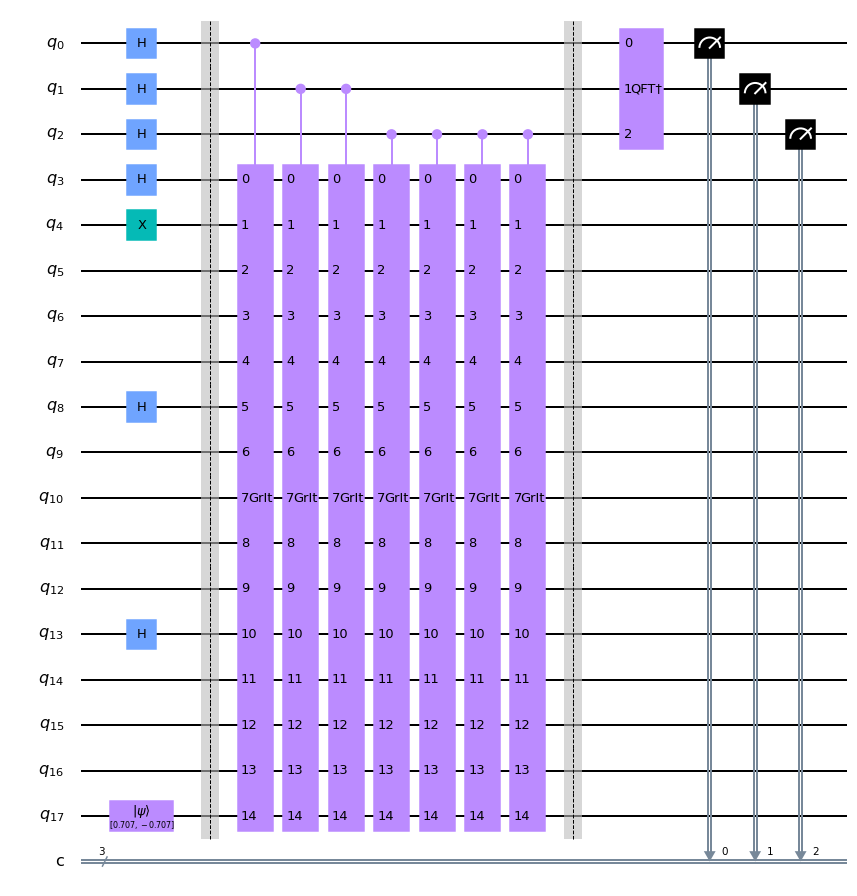

In [5]:

t = 3   # no. of counting qubits
n = 15   # no. of searching qubits

countingCircuit = QuantumCircuit(t+n, t)

cgrit = controlled_grover_iteration()

for qubit in range(t):
    countingCircuit.h(qubit)

threshold = "100"

if threshold[0] == "1":
    countingCircuit.x(4)
if threshold[1] == "1":
    countingCircuit.x(9)
if threshold[2] == "1":
    countingCircuit.x(14)

countingCircuit.initialize([1, -1]/np.sqrt(2), 17)
countingCircuit.h([3,8,13])

countingCircuit.barrier()

iterations = 1
for qubit in range(t):
    for i in range(iterations):
        countingCircuit.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2

countingCircuit.barrier()

qft_dagger = qft(t).to_gate().inverse()
qft_dagger.label = "QFT†"

countingCircuit.append(qft_dagger, range(t))

countingCircuit.measure(range(t), range(t))

countingCircuit.draw()

In [13]:
qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 128
results = execute(countingCircuit, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)